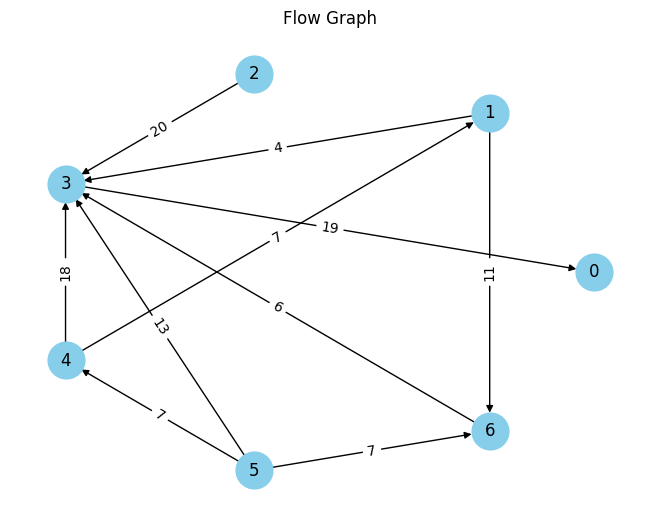

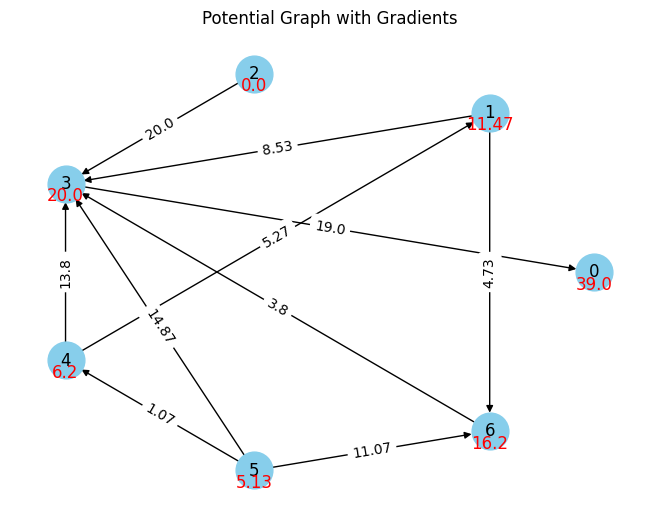

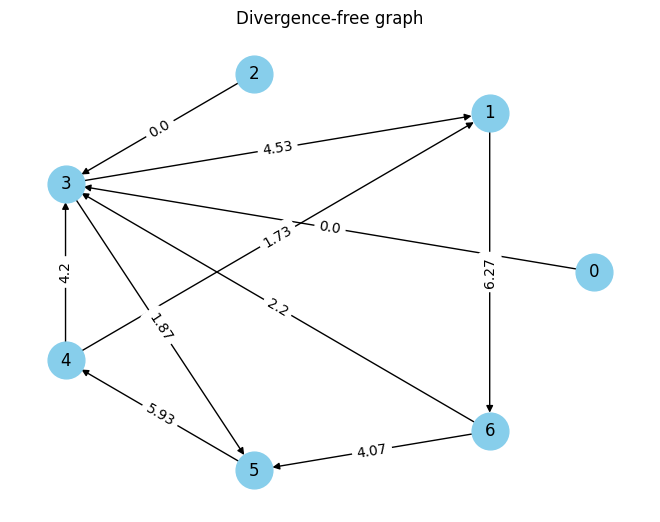

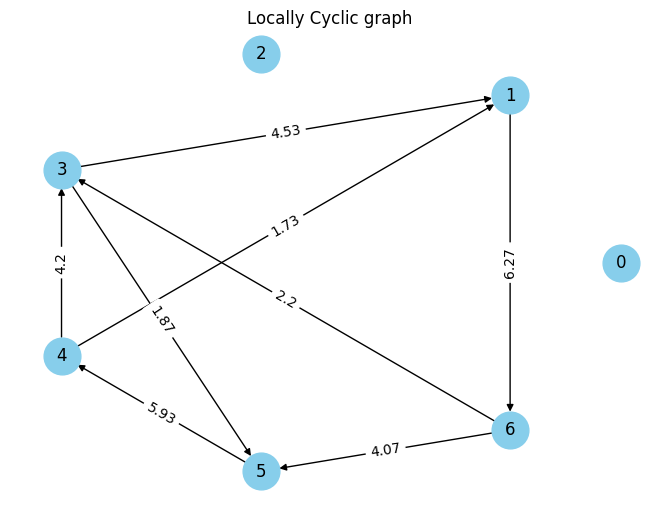

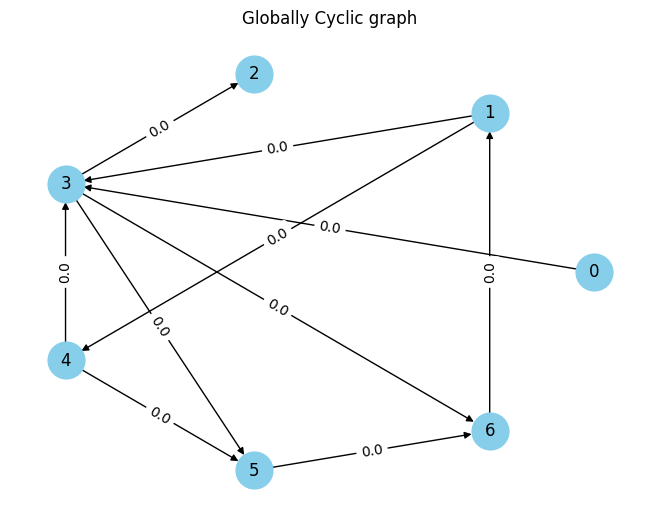

In [5]:
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from itertools import combinations
import math

def generate_circle_positions(n, radius=5):
    positions = {}
    for i in range(n):
        angle = 2 * math.pi * i / n
        x = radius * math.cos(angle)
        y = radius * math.sin(angle)
        positions[i] = (x, y)
    return positions

def pseudoinv(matrix):
    U,s,VT = np.linalg.svd(matrix)
    V = VT.T
    s_1 = np.array([1/i if i>1e-10 else 0 for i in s])
    dim_V = V.shape[0]
    dim_U = U.shape[0]
    if dim_U > dim_V:
        pseudoinv = V@np.hstack((np.diag(s_1),  np.zeros((len(s_1), dim_U-dim_V))))@U.T
    elif dim_U < dim_V:
        pseudoinv = V@np.vstack((np.diag(s_1),  np.zeros((dim_V-dim_U, len(s_1)))))@U.T
    else:
        pseudoinv = V@np.diag(s_1)@U.T
    return pseudoinv

def get_potential(random_graph):
    incidence_matrix = nx.incidence_matrix(random_graph, oriented=True).toarray()
    adjacency_matrix = nx.adjacency_matrix(random_graph).toarray()
    adjacency_matrix = adjacency_matrix-adjacency_matrix.T
    edge_flows = np.array([[val for (key,val) in nx.get_edge_attributes(random_graph, 'weight').items()]]).T
    node_potentials = pseudoinv(incidence_matrix.T)@edge_flows
    node_potentials = node_potentials-min(node_potentials)
    node_potentials_dict = {i:round(node_potentials[i][0],2) for i in range(len(node_potentials))}
    weight_matrix = (node_potentials@np.ones([1,len(node_potentials)])).T-node_potentials@np.ones([1,len(node_potentials)])
    weight_matrix[weight_matrix < 0] = 0
    weight_matrix_2 = (adjacency_matrix-(weight_matrix-weight_matrix.T))
    weight_matrix_2[weight_matrix_2<0] = 0
    return node_potentials, node_potentials_dict,weight_matrix,weight_matrix_2,incidence_matrix,edge_flows,adjacency_matrix

# def get_potential(random_graph):
#     incidence_matrix = nx.incidence_matrix(random_graph, oriented=True).toarray()
#     adjacency_matrix = nx.adjacency_matrix(random_graph).toarray()
#     adjacency_matrix = adjacency_matrix-adjacency_matrix.T
#     edge_flows = np.array([[val for (key,val) in nx.get_edge_attributes(random_graph, 'weight').items()]]).T
#     node_potentials = np.concatenate((np.linalg.inv((incidence_matrix@incidence_matrix.T)[:,:-1].T@(incidence_matrix@incidence_matrix.T)[:,:-1])\
#         @(incidence_matrix@incidence_matrix.T)[:,:-1].T@incidence_matrix@edge_flows,np.array([[0]])))
#     node_potentials = node_potentials-min(node_potentials)
#     node_potentials_dict = {i:round(node_potentials[i][0],2) for i in range(len(node_potentials))}
#     weight_matrix = (node_potentials@np.ones([1,len(node_potentials)])).T-node_potentials@np.ones([1,len(node_potentials)])
#     weight_matrix[weight_matrix < 0] = 0
#     weight_matrix_2 = (adjacency_matrix-(weight_matrix-weight_matrix.T))
#     weight_matrix_2[weight_matrix_2<0] = 0
#     return node_potentials, node_potentials_dict,weight_matrix,weight_matrix_2,incidence_matrix,edge_flows,adjacency_matrix

def get_triple_edge_incidence(random_graph):
    edge_list = [key for key,val in nx.get_edge_attributes(random_graph, 'weight').items()]
    edge_val_list = np.array([[val] for key,val in nx.get_edge_attributes(random_graph, 'weight').items()])
    combinations_2 = list(combinations(edge_list, 2))
    sets_2 = [set(i) for i in edge_list]
    sets_3 = set()
    triple_list = []
    for (c1,c2) in  combinations_2:
        set_1 = set(c2).union(set(c1))-set(c2).intersection(set(c1))
        if set_1 in sets_2 and set(c2).union(set(c1)) not in sets_3:
            sets_3.add(frozenset(set(c2).union(set(c1))))
            tuple_1 = tuple(set(c2).union(set(c1)))
            tuple_dict = {}
            if tuple_1[:2] in edge_list:
                tuple_dict[tuple_1[:2]] = 1
            else:
                tuple_dict[(tuple_1[:2][1],tuple_1[:2][0])] = -1
            if tuple_1[1:] in edge_list:
                tuple_dict[tuple_1[1:]] = 1
            else:
                tuple_dict[(tuple_1[1:][1],tuple_1[1:][0])] = -1
            tuple_3 = (tuple_1[2],tuple_1[0])
            if tuple_3 in edge_list:
                tuple_dict[tuple_3] = 1
            else:
                tuple_dict[(tuple_3[1],tuple_3[0])] = -1
            if tuple_dict not in triple_list:
                triple_list.append(tuple_dict)
    incidence_matrix = np.zeros([len(triple_list),len(edge_list)])
    for idx,i in enumerate(triple_list):
        for key in i.keys():
            incidence_matrix[idx,edge_list.index(key)] = i[key]
    return triple_list,edge_list,edge_val_list,incidence_matrix

def get_locally_cyclic(random_graph):
    triple_list,edge_list,edge_val_list,triple_edge_incidence_matrix = get_triple_edge_incidence(random_graph)
    triple_vals = pseudoinv(triple_edge_incidence_matrix.T)@edge_val_list
    locally_cyclic_edge_vals = triple_edge_incidence_matrix.T@triple_vals
    graph = nx.DiGraph()
    nodes = list(range(len(random_graph.nodes)))
    graph.add_nodes_from(nodes)
    for idx,val in enumerate(locally_cyclic_edge_vals):
        if val > 0:
                graph.add_edge(edge_list[idx][0], edge_list[idx][1], weight=val[0])
        if val < 0:
                graph.add_edge(edge_list[idx][1], edge_list[idx][0], weight=-val[0])
    return graph,locally_cyclic_edge_vals, nx.adjacency_matrix(graph).toarray()-nx.adjacency_matrix(graph).toarray().T

def graph_helmholzian(random_graph):
    incidence_matrix = nx.incidence_matrix(random_graph, oriented=True).toarray()
    triple_list,edge_list,edge_val_list,triple_edge_incidence_matrix = get_triple_edge_incidence(random_graph)
    helmholzian = triple_edge_incidence_matrix.T@triple_edge_incidence_matrix+incidence_matrix.T@incidence_matrix
    return helmholzian

def get_globally_cyclic(random_graph):
    helmholzian = graph_helmholzian(random_graph)
    proj_matrix = np.eye(helmholzian.shape[0])-pseudoinv(helmholzian)@helmholzian
    edge_list = [key for key,val in nx.get_edge_attributes(random_graph, 'weight').items()]
    edge_val_list = np.array([[val] for key,val in nx.get_edge_attributes(random_graph, 'weight').items()])
    globally_cyclic_edge_vals = proj_matrix@edge_val_list
    graph = nx.DiGraph()
    nodes = list(range(len(random_graph.nodes)))
    for idx,val in enumerate(globally_cyclic_edge_vals):
        if val > 0:
                graph.add_edge(edge_list[idx][0], edge_list[idx][1], weight=val[0])
        if val < 0:
                graph.add_edge(edge_list[idx][1], edge_list[idx][0], weight=-val[0])
    return graph,globally_cyclic_edge_vals, nx.adjacency_matrix(graph).toarray()-nx.adjacency_matrix(graph).toarray().T

def generate_random_directed_graph(k, n):
    graph = nx.DiGraph()
    nodes = list(range(k))
    graph.add_nodes_from(nodes)
    edges_generated = 0
    visited_edges = set()  # Set to keep track of visited edges
    while edges_generated < n:
        source = random.choice(nodes)
        target = random.choice(nodes)
        if source != target and not graph.has_edge(source, target):
            # Ensure that there is only one directed edge between any two nodes
            if (source, target) not in visited_edges and (target, source) not in visited_edges:
                weight = random.randint(1, 20)  # Random weight
                graph.add_edge(source, target, weight=weight)
                visited_edges.add((source, target))  # Add the edge to the visited set
                edges_generated += 1
    return graph


def create_graph_from_weight_matrix(weight_matrix, reference_graph=None):
    graph = nx.DiGraph()
    nodes = list(range(weight_matrix.shape[0]))
    graph.add_nodes_from(nodes)
    if reference_graph is not None:
        reference_edges = set(reference_graph.edges())
    else:
        reference_edges = set(nx.complete_graph(len(graph.nodes())).edges())
    for i in range(weight_matrix.shape[0]):
        for j in range(weight_matrix.shape[1]):
            weight = weight_matrix[i, j]
            # Add the edge if weight is non-zero and it's present in the reference graph
            if weight != 0 and ((i, j) in reference_edges or (j, i) in reference_edges):
                graph.add_edge(i, j, weight=weight)
    return graph

def plot_directed_graph(graph,title,node_labels=None,edge_labels=None):
    n = len(graph.nodes)
    pos = generate_circle_positions(n)
    # pos = nx.shell_layout(graph)  # Positions for all nodes
    labels = nx.get_edge_attributes(graph, 'weight')  # Get edge weights
    nx.draw(graph, pos, with_labels=True, node_size=700, node_color='skyblue')
    pos_nodes = {node: (x, y - 0.3) for node, (x, y) in pos.items()}
    if node_labels != None:
        nx.draw_networkx_labels(graph, pos_nodes, labels=node_labels, font_color='red')
    if edge_labels != None:
        nx.draw_networkx_edge_labels(graph, pos, label_pos=0.5, edge_labels=edge_labels)
    plt.title(title)
    plt.show()

k = 7  # Number of nodes
n = 10  # Number of edges
random_graph = generate_random_directed_graph(k, n)
plot_directed_graph(random_graph,"Flow Graph",edge_labels=nx.get_edge_attributes(random_graph, 'weight'))
node_potentials, node_potentials_dict,weight_matrix,weight_matrix_2,incidence_matrix,edge_flows,adjacency_matrix = get_potential(random_graph)
random_graph_2 = create_graph_from_weight_matrix(weight_matrix,random_graph)
nx.set_node_attributes(random_graph_2, node_potentials_dict, 'potential')
edge_labels = {key:round(val,2) for key,val in nx.get_edge_attributes(random_graph_2, 'weight').items()}
plot_directed_graph(random_graph_2,"Potential Graph with Gradients",node_labels=node_potentials_dict,edge_labels=edge_labels)
random_graph_3 = create_graph_from_weight_matrix(weight_matrix_2,random_graph)
nx.set_node_attributes(random_graph_3, node_potentials_dict, 'potential')
edge_labels = {key:round(val,2) for key,val in nx.get_edge_attributes(random_graph_3, 'weight').items()}
plot_directed_graph(random_graph_3,"Divergence-free graph",edge_labels=edge_labels)
random_graph_4,locally_cyclic_edge_vals, locally_cyclic_adjacency_matrix = get_locally_cyclic(random_graph)
nx.set_node_attributes(random_graph_4, node_potentials_dict, 'potential')
edge_labels = {key:round(val,2) for key,val in nx.get_edge_attributes(random_graph_4, 'weight').items()}
plot_directed_graph(random_graph_4,"Locally Cyclic graph",edge_labels=edge_labels)
random_graph_5,globally_cyclic_edge_vals, globally_cyclic_adjacency_matrix = get_globally_cyclic(random_graph)
nx.set_node_attributes(random_graph_5, node_potentials_dict, 'potential')
edge_labels = {key:round(val,2) for key,val in nx.get_edge_attributes(random_graph_5, 'weight').items()}
plot_directed_graph(random_graph_5,"Globally Cyclic graph",edge_labels=edge_labels)